# Three word weather hack

## Important word categories

In this section we will look to answer the question:

> What categories of words are more important?

To answer this we need to get all the unique words from the dataset and sort them into categories. Then we can plot the dataset in terms of those categories in different ways to try and answer the question.

In [4]:
# Import libraries to be used later
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [5]:
# Define some constants for later use
CORPORATE_COLOURS = ['#50B9A4', '#007AA9', '#E47452', '#A1A0AA', '#B9DC0C', '#FADF63']

Let's load the processed three word weather dataset.

In [6]:
processed_tweets = pd.read_csv('/s3/three-word-weather/hack/3ww-processed.csv',
                               header=None,
                               names=['created_at', 'username', 'tweet', 'word1', 'word2', 'word3', 'location', 'lat', 'lon'],
                               na_values=' ',
                               dtype={'lat': np.float, 'lon': np.float})

# Display first few rows of the table
processed_tweets.head()

,created_at,username,tweet,word1,word2,word3,location,lat,lon
0,2018-02-08 14:09:57,b'laurelturner12',b'RT @LaurelT35782990: #3wordweather cold drea...,cold,dreary,overcast,eastbourne,50.768035,0.290472
1,2018-02-08 13:40:07,b'PeterSainsbury',"b'@metoffice #3wordweather cool, dry, overcast...",cool,dry,overcast,shepperton middlesex,51.388695,-0.456544
2,2018-02-08 12:27:56,b'Streakyblue1951',b'@metoffice cold grey spitting Portsmouth #3w...,cold,grey,spitting,portsmouth,50.819767,-1.087977
3,2018-02-08 10:29:24,b'pscollier',"b'@metoffice #3WordWeather Warm, breezy, hazy....",warm,breezy,hazy,yangon myanmar,16.866069,96.195132
4,2018-02-08 10:09:04,b'unit2plus4',b'@metoffice Cloudy dry soggy #3wordweather',cloudy,dry,soggy,NaN,NaN,NaN


We also manually produced a categorised set of the 500 must commonly used words. Let's load that too.

The categories are:
 - precipitation
 - sky_state
 - wind
 - temperature
 - swearing
 - misc

We'll then sort that into a dictionary where each category is a key and a list of words in the category is the value.

In [7]:
# Load words
categorised_words = pd.read_csv('/s3/three-word-weather/hack/categorised_words.csv', header=0, names=['word', 'weight', 'category'], na_values=' ')
    
# Build dictionary
categories = {}
for index, item in categorised_words.iterrows():
    item['category'] = item['category'].strip().replace(' ', '_').lower()
    if item['category'] in categories:
        categories[item['category']].append(item["word"])
    else:
        categories[item['category']] = [item["word"]]

# Output a few examples
{category: words[:4] for category, words in categories.items()}

{'misc': ['correctness', 'gringey', 'could', 'sparta'],
 'precipitation': ['stottin', 'rain-shadow', 'sticking', 'hammering-it-down'],
 'sky_state': ['thunder', 'coloured', 'braw', 'fair'],
 'swearing': ['fecking', 'fuckety', 'pissin', 'f**king'],
 'temperature': ['crispy', 'sharpe', 'fridge-fresh', 't-shirts'],
 'wind': ['gale', 'nw', 'thin-wind', 'hooley']}

Now we can create our list of all the words from the three word weather dataset, count the number of ocurrences of each word and categorise them.

In [8]:
all_words = pd.concat([processed_tweets['word1'].str.lower().str.strip(), processed_tweets['word2'].str.lower().str.strip(), processed_tweets['word3'].str.lower().str.strip()])

counts = {}
for word, percentage in all_words.value_counts(normalize=True).items():
    for category, wordlist in categories.items():
        category = category.lower().strip().replace(' ', '_')
        if word in wordlist:
            if category in counts:
                counts[category] += percentage
            else:
                counts[category] = percentage
                
counts

{'misc': 0.16467412263787179,
 'precipitation': 0.1673736984188203,
 'sky_state': 0.25723100655611242,
 'swearing': 0.047821056691091449,
 'temperature': 0.26841496336289922,
 'wind': 0.082144234477439335}

This gives us a dictionary of the categories with the percentage of words in that category on a scale of 0 to 1. Adding these may not add up to 1 as this dataset only covers the 500 most common words.

To plot this on a graph let's recale the categories to be a percentage between 0 and 100 and ensure they do add up to 100. Then we'll draw a bar chart of the values.

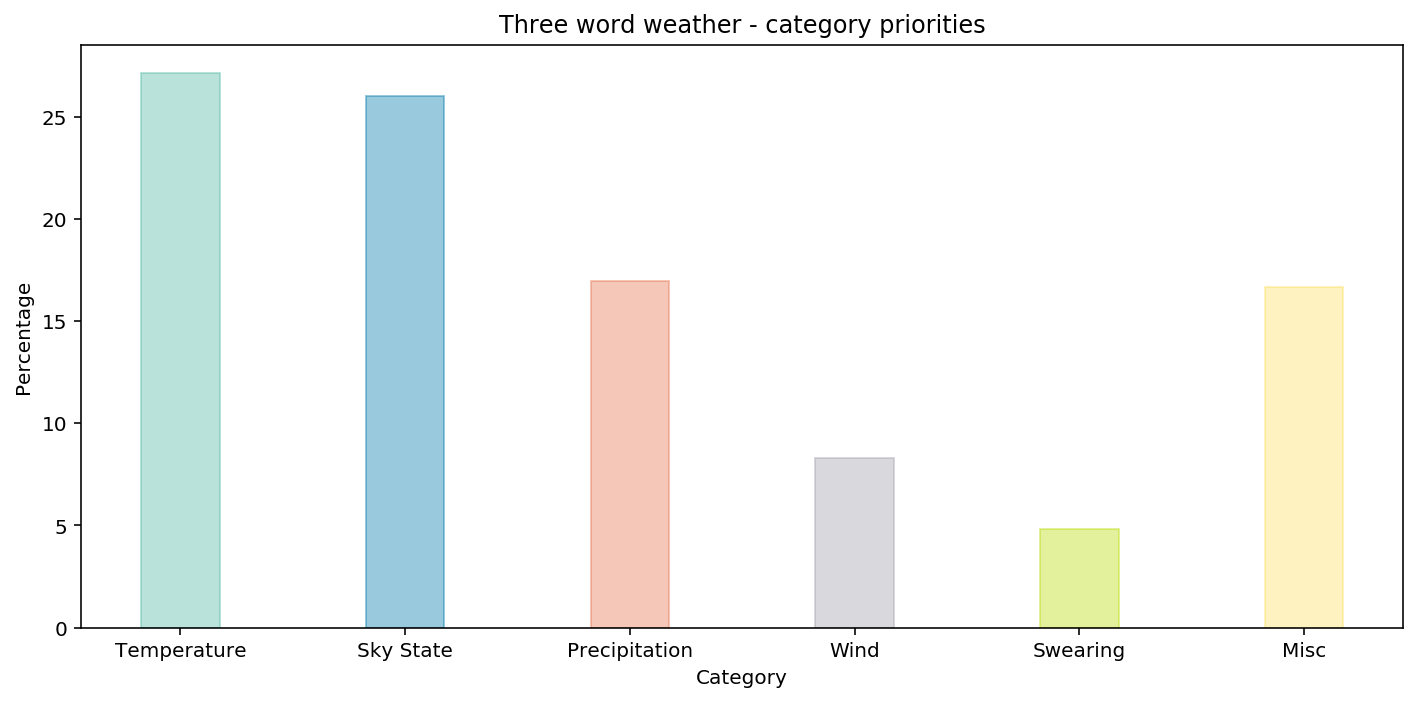

In [9]:
# I'm using a MacBook pro so let's ensure matplotlib renders for my retina display
%config InlineBackend.figure_format = 'retina'

# Rescale values and get keys.
values = [x / sum(counts.values()) * 100 for x in counts.values()]
labels = [label.replace('_', ' ').title() for label in counts.keys()]

# Create a figure
fig, ax = plt.subplots(figsize=(10, 5))

# Set the bar indexes (equally spaced is fine)
index = np.arange(len(values))

# Set stylistic properties
bar_width = 0.35
opacity = 0.4

# Create the bars from the data
bars = ax.bar(index, values, bar_width, alpha=opacity, color='b')

# Apply the corporate colours to the bars
for i, bar in enumerate(bars):
    bar.set_color(CORPORATE_COLOURS[i])

# Label up the plot
ax.set_xlabel('Category')
ax.set_ylabel('Percentage')
ax.set_title('Three word weather - category priorities')
ax.set_xticklabels([None] + labels)

# Draw it!
fig.tight_layout()
plt.show()

This is an interesting plot but it begs more questions than it answers. For example are there more tempterature and sky state words because those were the things driving the impacts at the time? If it had been raining more would we have seen more precipitation words.

One better way to display this data could be to visualise each word individually within the three word weather format. Perhaps people put the more important categories first and then less important ones second or third.

Let's build a count of the data similar to before but instead keep `word1`, `word2` and `word3` in separate dictionaries.

In [10]:
all_counts = []

for wordset in processed_tweets['word1'].str.lower().str.strip(), processed_tweets['word2'].str.lower().str.strip(), processed_tweets['word3'].str.lower().str.strip():             
    counts = {}
    for word, percentage in wordset.value_counts(normalize=True).items():
        for category, wordlist in categories.items():
            category = category.lower().strip().replace(' ', '_')
            if word in wordlist:
                if category in counts:
                    counts[category] += percentage
                else:
                    counts[category] = percentage
    all_counts.append(counts)
                
all_counts

[{'misc': 0.14806378132118442,
  'precipitation': 0.15148063781321178,
  'sky_state': 0.30751708428246011,
  'swearing': 0.062642369020501132,
  'temperature': 0.2801822323462414,
  'wind': 0.037585421412300674},
 {'misc': 0.22873563218390744,
  'precipitation': 0.15402298850574697,
  'sky_state': 0.24137931034482746,
  'swearing': 0.066666666666666652,
  'temperature': 0.21379310344827565,
  'wind': 0.086206896551724116},
 {'misc': 0.1159763313609469,
  'precipitation': 0.19763313609467431,
  'sky_state': 0.2213017751479287,
  'swearing': 0.01301775147928994,
  'temperature': 0.31242603550295894,
  'wind': 0.12426035502958585}]

Now we can plot the category distributions for each word separately and see if there is any kind of order.

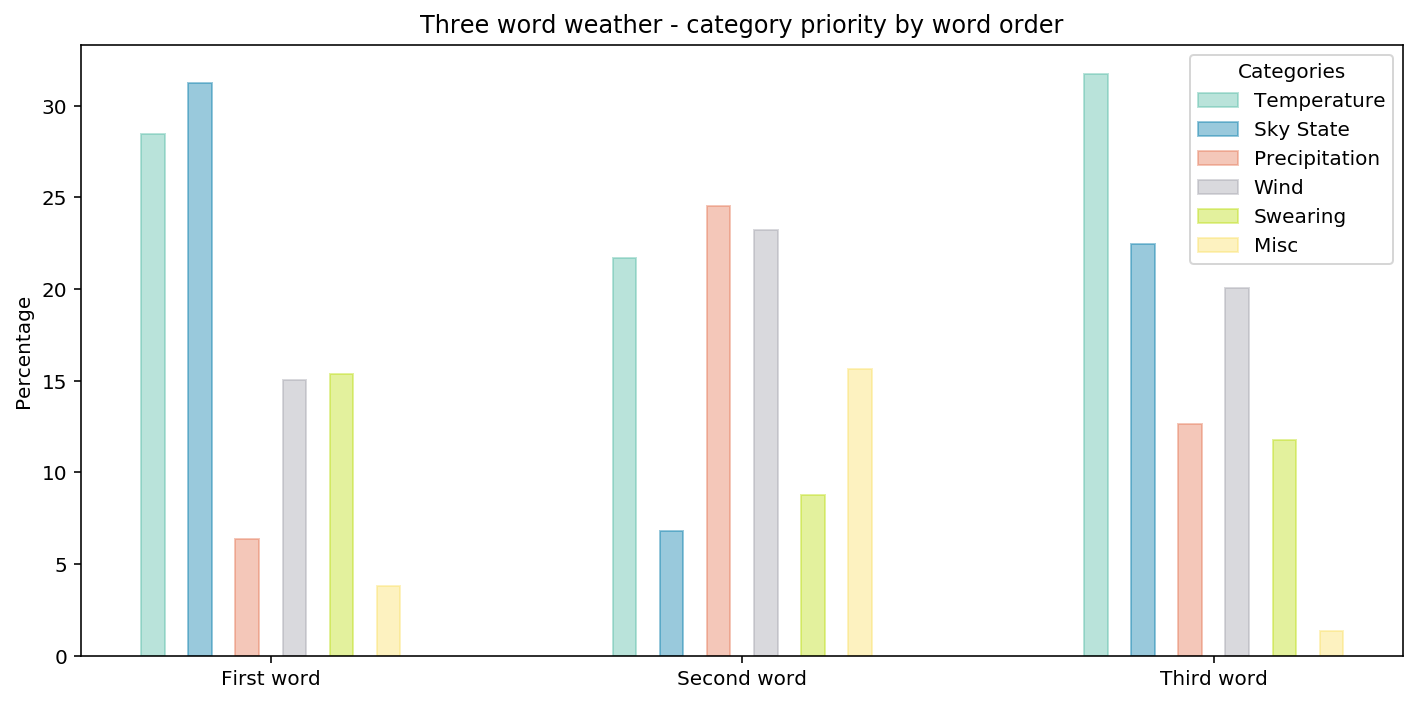

In [11]:
# Create a list of all the values
grouped_values = []
for group in all_counts:
    grouped_values.append([x / sum(counts.values()) * 100 for x in group.values()])

# Create a new figure
fig, ax = plt.subplots(figsize=(10, 5))

# Generate the index but this time space out the three groups
group_spacing = 10
index = []
for i, _ in enumerate(range(len(all_counts))):
    index += [x + (group_spacing * i) for x in range(len(values))]

# Set stylistic properties
bar_width = 0.5
opacity = 0.4

# Create the bars from the data
bars = ax.bar(index, grouped_values[0] + grouped_values[1] + grouped_values[2], bar_width, alpha=opacity, color='b')

# Set the corporate colours (but cycle through a few times)
for i, bar in enumerate(bars):
    bar.set_color(CORPORATE_COLOURS[i % len(CORPORATE_COLOURS)])

# Label the plot
ax.set_ylabel('Percentage')
ax.set_title('Three word weather - category priority by word order')

# Add a legend this time as we will use the x axis to show the word groups
ax.legend(title='Categories', handles=[mpatches.Patch(color=CORPORATE_COLOURS[i % len(CORPORATE_COLOURS)], alpha=opacity, label=label) for i, label in enumerate(labels)])

# Add labels to the word groups
ax.set_xticks([2.5, 12.5, 22.5])
ax.set_xticklabels(['First word', 'Second word', 'Third word'])

# Draw the plot
fig.tight_layout()
plt.show()

This plot shows that temperature and sky state are the first thing on people's mind, followed by wind and precipitation. It also shows people are more likely to swear in the middle.

However these results could show that the temperature and sky state were the most prominent weather feature at the time this data was collected and therefore first on peoples minds rather than because these things are more important to people.

## Word probabilities

In this section we will look to answer the question:

> What temperature ranges do people associate with different words?

In [12]:
categorised_words = pd.read_csv('/s3/three-word-weather/hack/categorised_words.csv', header=0, names=['word', 'weight', 'category'], na_values=' ')
top_words = list(categorised_words.loc[categorised_words['category'] == 'temperature'].sort_values(by=['weight'], ascending=False)[:10]['word'])

In [13]:
processed_tweets_with_obs = pd.read_csv('/s3/three-word-weather/hack/3ww-processed-with-obs.csv')
processed_tweets_with_obs.head()

,Unnamed: 0,created_at,username,tweet,word1,word2,word3,location,lat,lon,datetime,obs
0,0,2018-02-08 14:09:57,elturner,LaurelT35782990: #3wordweather cold dreary ove...,cold,dreary,overcast,eastbourne,50.768035,0.290472,2018-02-08 14:09:57,"b'{""latitude"":50.768035,""longitude"":0.29047199..."
1,1,2018-02-08 13:40:07,rSainsbu,"office #3wordweather cool, dry, overcast; Shep...",cool,dry,overcast,shepperton middlesex,51.388695,-0.456544,2018-02-08 13:40:07,"b'{""latitude"":51.388695,""longitude"":-0.4565439..."
2,2,2018-02-08 12:27:56,akyblue19,office cold grey spitting Portsmouth #3wordweath,cold,grey,spitting,portsmouth,50.819767,-1.087977,2018-02-08 12:27:56,"b'{""latitude"":50.819767,""longitude"":-1.087977,..."
3,3,2018-02-08 10:29:24,lli,"office #3WordWeather Warm, breezy, hazy. Yango...",warm,breezy,hazy,yangon myanmar,16.866069,96.195132,2018-02-08 10:29:24,"b'{""latitude"":16.866069,""longitude"":96.195132,..."
4,5,2018-02-07 22:59:01,eMaye,"Michelle_Mc84: @metoffice Cold, icey, sunny on...",cold,icey,sunny,dartmoor,50.571886,-3.920688,2018-02-07 22:59:01,"b'{""latitude"":50.571886,""longitude"":-3.9206879..."


In [14]:
processed_tweets_with_obs = processed_tweets_with_obs[processed_tweets_with_obs['obs'] != 'FAILED']

In [15]:
processed_tweets_with_obs = processed_tweets_with_obs[processed_tweets_with_obs['obs'] != 'FAILED']
processed_tweets_with_obs = processed_tweets_with_obs.drop(processed_tweets_with_obs.index[[201]])

In [16]:
processed_tweets_with_obs['t_ob'] = processed_tweets_with_obs['obs'].apply(lambda x: json.loads(x[2:-1])['currently']['temperature'])
processed_tweets_with_obs['flt_ob'] = processed_tweets_with_obs['obs'].apply(lambda x: json.loads(x[2:-1])['currently']['apparentTemperature'])

In [17]:
processed_tweets_with_obs['flt_ob'] = processed_tweets_with_obs['flt_ob'].apply(lambda x: (x - 32) * (5/9))

In [18]:
def weather_word_search(df, keyword):
    return df[(df['word1'] == keyword) | (df['word2'] == keyword) | (df['word3'] == keyword)]

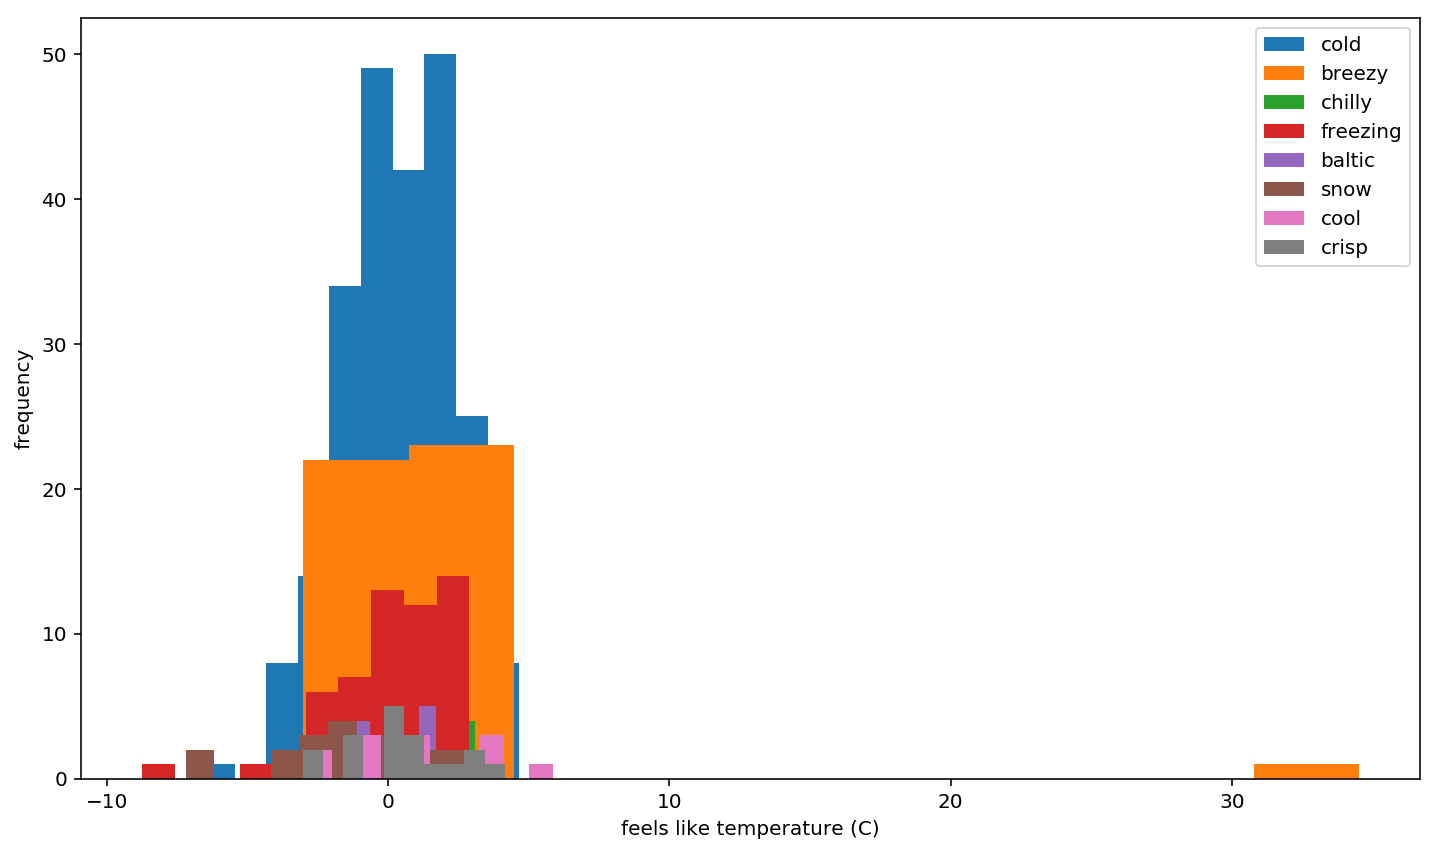

In [19]:
plt.figure(figsize=(12,7))

plt.xlabel('feels like temperature (C)')
plt.ylabel('frequency')

plt.hist(weather_word_search(processed_tweets_with_obs, 'cold')['flt_ob'], label='cold');
plt.hist(weather_word_search(processed_tweets_with_obs, 'breezy')['flt_ob'], label='breezy');
plt.hist(weather_word_search(processed_tweets_with_obs, 'chilly')['flt_ob'], label='chilly');
plt.hist(weather_word_search(processed_tweets_with_obs, 'freezing')['flt_ob'], label='freezing');
plt.hist(weather_word_search(processed_tweets_with_obs, 'baltic')['flt_ob'], label='baltic');
plt.hist(weather_word_search(processed_tweets_with_obs, 'snow')['flt_ob'], label='snow');
plt.hist(weather_word_search(processed_tweets_with_obs, 'cool')['flt_ob'], label='cool');
plt.hist(weather_word_search(processed_tweets_with_obs, 'crisp')['flt_ob'], label='crisp');

# plt.figure(figsize=(60,100))
plt.legend()

In [20]:
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from bokeh.transform import jitter

output_notebook()

Loading BokehJS ...

In [21]:
from scipy.stats import ttest_rel, ttest_ind_from_stats

In [22]:
cold = weather_word_search(processed_tweets_with_obs, 'cold')["flt_ob"]
freezing = weather_word_search(processed_tweets_with_obs, 'freezing')["flt_ob"]
chilly = weather_word_search(processed_tweets_with_obs, 'chilly')["flt_ob"]
cool = weather_word_search(processed_tweets_with_obs, 'cool')["flt_ob"]
crisp = weather_word_search(processed_tweets_with_obs, 'crisp')["flt_ob"]
brass = weather_word_search(processed_tweets_with_obs, 'brass')["flt_ob"]
fresh = weather_word_search(processed_tweets_with_obs, 'fresh')["flt_ob"]

def ttest(a, b):
    return ttest_ind_from_stats(a.mean(), a.std(), len(a), b.mean(), b.std(), len(b))


In [23]:
ttest(cool, fresh)

Ttest_indResult(statistic=1.4272605014106901, pvalue=0.16973379896594878)

In [24]:
cold1 = cold.sample(frac=0.5)
cold2 = cold.sample(frac=0.5)

ttest(cold1, cold2)

Ttest_indResult(statistic=0.39087087390782754, pvalue=0.69625449992065458)

In [25]:
ttest(cold, freezing)

Ttest_indResult(statistic=1.3895849207928606, pvalue=0.16573952400354836)

In [26]:
all_raw_tweets = pd.read_csv('/s3/three-word-weather/hack/3ww-all-raw.csv',
                               header=None,
                               names=['created_at', 'username', 'tweet'],
                               na_values=' ',
                               dtype={'lat': np.float, 'lon': np.float},
                               date_parser=pd.datetools.to_datetime,
                               parse_dates=['created_at'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pandas.core.datetools.to_datetime is deprecated. Please use pandas.tseries.tools.to_datetime instead.
  


In [27]:
["{} {}".format(x, len(weather_word_search(processed_tweets_with_obs, x))) for x in top_words]

['cold 231',
 'freezing 56',
 'chilly 49',
 'baltic 22',
 'cool 14',
 'crisp 18',
 'nippy 6',
 'fresh 7',
 'brass 7',
 'parky 8']

In [28]:
numberly = pd.read_csv('numberly.csv')
ttest(numberly["Many"], numberly["A lot"])

Ttest_indResult(statistic=-0.61014271518272756, pvalue=0.54330483635917393)

In [29]:
probly = pd.read_csv('probly.csv')
ttest(probly["Likely"], probly["Unlikely"])

Ttest_indResult(statistic=25.066146363726819, pvalue=2.2847490389811226e-42)

In [30]:
cold_tweets = all_raw_tweets[all_raw_tweets['tweet'].str.lower().str.contains("cold")]

In [31]:
cold_tweets.head()

,created_at,username,tweet
0,2018-03-05 11:43:14,b'EdwardAndrews5',"b'#3wordweather cold, dry, windy. Ardersier'"
5,2018-03-04 13:03:17,b'CharleesAunt',b'#3wordweather Misty rain cold #thirsk #north...
9,2018-03-04 10:57:03,b'copsey_david',b'Cold damp dull #3wordweather'
11,2018-03-04 10:43:30,b'StephenStaple13',b'#3WORDWEATHER Fog Damp Cold. Melton Mowbray'
14,2018-03-04 10:00:04,b'mysouthend',b'RT @tsingleton: #3wordweather sunny cold slu...


In [32]:
known_places = list(processed_tweets[["location", "lat", "lon"]].drop_duplicates('location')['location'])

In [33]:
len(cold_tweets[cold_tweets["tweet"].apply(lambda x: any([str(y) in x.lower() for y in known_places]))])

157

In [34]:
len(cold_tweets)

648